In [1]:
import torch
import torch.nn as nn
from fastai.vision.all import *

In [2]:
# import gdown
# # download the dataset
# url = "https://drive.google.com/uc?id=1ffJr3NrYPqzutcXsYIVNLXzzUaC9RqYM"
# output = 'catface.tgz'
# gdown.download(url, output, quiet = False)

In [3]:
# from zipfile import ZipFile

# with ZipFile('catface.tgz', 'r') as zip_ref:
#     zip_ref.extractall()

In [8]:
import os

[x[0] for x in os.walk('../datasets/cats/')]

['../datasets/cats/',
 '../datasets/cats/CAT_04',
 '../datasets/cats/CAT_03',
 '../datasets/cats/CAT_05',
 '../datasets/cats/CAT_01',
 '../datasets/cats/CAT_02',
 '../datasets/cats/CAT_06',
 '../datasets/cats/CAT_00']

In [9]:
for i in range(7):
    path = Path('../datasets/cats/' + f'CAT_0{i}')
    shutil.rmtree(path)

In [11]:
# use 'pathlib' to move all the files up one level
# for i in range(7):
#     paths = Path('../datasets/cats/' + f'CAT_0{i}').ls()
#     for path in paths:
#         p = Path(path).absolute()
#         par = p.parents[1] # ?
#         p.rename(par/p.name)

In [20]:
path = Path('../datasets/' + 'cats/')
print('======> the focused path', path)
lbls = get_files(path, extensions = '.cat')
imgs = get_image_files(path)
test_result = test_eq(len(lbls), len(imgs))
print('======> Equal Length', test_result)

======> the focused path ../datasets/cats
======> Equal Length None


<AxesSubplot:>

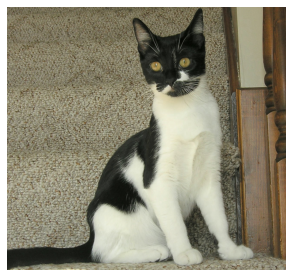

In [21]:
# visualizing the data
def img2kpts(f):
    return f'{str(f)}.cat'

fname = imgs[0]
img = PILImage.create(fname)
img.show()

It is, go back to the Kaggle and they describe how it is done.  
 The number of points by default are 9 (the first value in our list):

| Left eye   | Right eye  | Mouth      |
| ----       | ---        | ---        |
| Left ear 1 | Left ear 2 | Left ear 3 |
| Right ear 1| Right ear 2| Right ear 3|

In [22]:
import numpy as np

kpts = np.genfromtxt(img2kpts(fname))
print(kpts)

[  9. 547. 216. 650. 203. 602. 292. 486. 171. 468.  43. 546. 110. 651.
  98. 709.   9. 721. 146.]


In [23]:
# seperate the keypoints into pairs and a tensor
def set_points(coords:array):
    kpts = []
    for i in range(1, int(coords[0]*2), 2):
        kpts.append([coords[i], coords[i+1]])
    return tensor(kpts)

In [24]:
pnts = set_points(kpts)
print(pnts)

tensor([[547., 216.],
        [650., 203.],
        [602., 292.],
        [486., 171.],
        [468.,  43.],
        [546., 110.],
        [651.,  98.],
        [709.,   9.],
        [721., 146.]])


In [25]:
def get_y(f:Path):
    # get keypoints for 'f' image
    pts = np.genfromtxt(img2kpts(f))
    return set_points(pts)

Now there is one more bit of cleaning we need to do, and that is to make sure all my points are within the bounds of my image.  
But how do I do this? Let's write a list of `bad_fnamesin` which we run the following test:  

1. Open an image and the points  
2. If any point is outside the image, remove the file  
3. If any point is negative, remove the file  

In [26]:
bad_imgs = []
for name in imgs:
    im = PILImage.create(name)
    y = get_y(name)
    for x in y:
        if x[0] < im.size[0]:
            if x[0] < 0:
                bad_imgs.append(name)
            if x[1] < im.size[1]:
                if x[1] < 0:
                    bad_imgs.append(name)
            else:
                bad_imgs.append(name)
        else:
            bad_imgs.append(name)

# take a look at: how many bad images we had
print('======> how many bad images we have:', len(bad_imgs))

======> how many bad images we have: 1430


Therefore, there are `len(bad_imgs)` images who's points go out of bounds.  
To deal with this, there are a few different ways:  
1. Remove said images
2. Zero those points to $(-1, 1)$ through a transform
3. keep the points (??? so what is this method?)

In [27]:
# We chhose the No.1. method
for name in list(set(bad_imgs)):
    name.unlink()

# after removing all the bad imgs
imgs = get_image_files(path)
fname = imgs[0]
img = PILImage.create(fname)

In [29]:
# to get the `TensorPoints`
def get_ip(imgs:PILImage, pts:array):
    return TensorPoint(pts, sz = img.size)

ip = get_y(fname)
print(ip)
tp = get_ip(img, ip)

tensor([[547., 216.],
        [650., 203.],
        [602., 292.],
        [486., 171.],
        [468.,  43.],
        [546., 110.],
        [651.,  98.],
        [709.,   9.],
        [721., 146.]])


<AxesSubplot:>

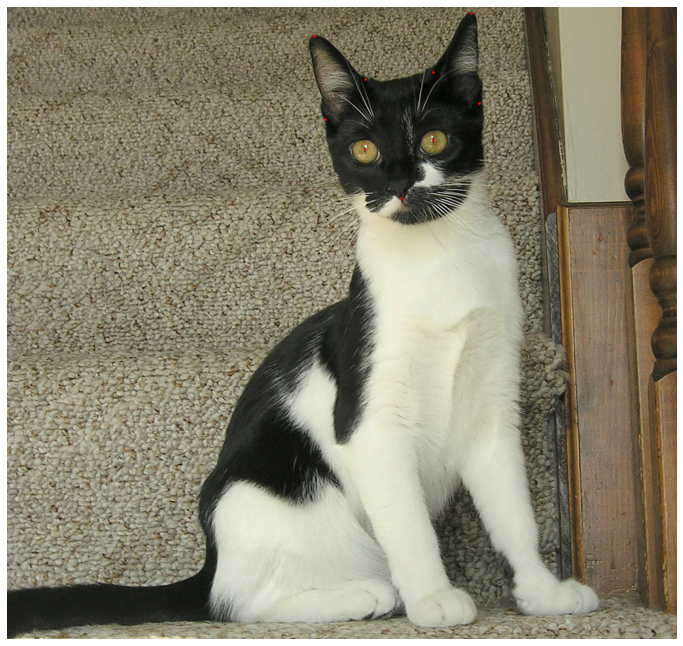

In [30]:
# Now we can visualize our points. We can pass in an axis to overlay them on top of our image
ax = img.show(figsize = (12, 12))
tp.show(ctx = ax)

## DataBlock and Train
* The 'Clamping' option. Can be useful for more than ground truth.
* Considering the case: RandomResizeCrop crops the image and makes the point go off-screen. Do we keep the point and let the model guess? Or adjust that point?


* build transform to adjust for this (our dataset will not use this but this is for an example)
* will use either 'padding' or 'squishing' on our resize

In [31]:
class ClampBatch(Transform):
    # clamp points to a minimum and maximum in a batch
    order = 4
    def __init__(self, min = -1, max = 1, **kwargs):
        super().__init__(**kwargs)
        self.min, self.max = min, max
    def encodes(self, x:(TensorPoint)):
        for i, set in enumerate(x):
            for j, pair in enumerate(sets):
                cpnt = torch.clamp(pair, self.min, self.max)
                if any(cpnt >= 1) or any(cpnt <= -1):
                    x[i][j] = tensor([-1, -1])
        return x

Go ahead and run `ClampBatch` though just in case something happens during one of our transforms (though most likely not)   
All keypoint agumentation available:  
* Rotate, FlipItem, Dihedralltem
* CropPad, RandomCrop, Resize, RandomResizeCrop
* Zoom, Warp

In [33]:
item_tfms = [Resize(448, method = 'squish')]
batch_tfms = [Flip(), Rotate(), Zoom(), Warp(), ClampBatch()]

dblock = DataBlock(blocks = (ImageBlock, PointBlock),
                   get_items = get_image_files,
                   splitter = RandomSplitter(),
                   get_y = get_y,
                   item_tfms = item_tfms,
                   batch_tfms = batch_tfms)

bs = 24

With how our `get_y` is, we will want a base path. Look at a `dblock.summary()` output now to see what's going on in our `Pipeline`

In [35]:
# dblock.summary('')

In [36]:
dls = dblock.dataloaders('', path = '', bs = bs)
dls.show_batch(max_n = 88, figsize = (12 ,12))

TypeError: 'NoneType' object is not iterable